In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, Linear, CFlow
from flows.config import floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.02
s0 = 0.45
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[-1] + np.random.normal(scale=s1, size=dim)
    params.append(new)
params = np.array(params, dtype=floatX)

PWalk = NormalRW(None, sigma=s1, sigma0=s0)

In [3]:
params.shape, params[0,0,0]

((32, 3, 4), 0.21214582367962187)

In [4]:
observ_std = 0.07

def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=observ_std)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X)[:,0] + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [6]:
xs

array([[[ 1.93464234e-01, -4.96744938e-01,  1.03272322e+00],
        [ 7.10603413e-01, -2.00919150e-01,  1.42183434e+00],
        [ 1.07420666e+00, -1.02354294e-01,  1.42958677e+00],
        [ 1.12812170e+00, -1.96849318e-01,  1.35667937e+00],
        [ 1.19191134e+00, -3.13971820e-01,  1.39904218e+00],
        [ 1.44836144e+00, -3.60622825e-01,  1.55039966e+00],
        [ 1.51738955e+00, -3.94575590e-01,  1.72697328e+00],
        [ 1.64518120e+00, -1.55751523e-01,  2.05954617e+00],
        [ 1.93182283e+00, -4.75234955e-03,  1.82964517e+00],
        [ 1.71150569e+00, -1.03043856e-01,  1.54524466e+00],
        [ 1.42083518e+00, -2.81987230e-01,  1.60378598e+00],
        [ 1.54145973e+00, -4.15680158e-01,  1.73974413e+00],
        [ 1.68464460e+00, -4.48550845e-01,  2.08756546e+00],
        [ 2.14688552e+00, -3.75741862e-01,  2.32043762e+00],
        [ 2.30865421e+00, -4.16004568e-01,  2.39870723e+00],
        [ 2.44590798e+00, -5.63656465e-01,  2.56920997e+00],
        [ 2.69030337e+00

In [7]:
# conf = [[ResFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)), 
#          NVPFlow(dim=n*dim[0]*dim[1], name='nvp{}'.format(i))] for i in range(2)]
# conf = sum(conf, [])

#conf = [NVPFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)) for i in range(4)]
conf = [Linear(dim=n*dim[0]*dim[1])]
# conf = [CFlow(dim=n*dim[0]*dim[1], name='CFlow')]

output_flow = DFlow(conf)

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [8]:
output_flow.output

<tf.Variable 'CFlow/W:0' shape=(384,) dtype=float64_ref>

In [9]:
outputs = tf.reshape(output_flow.output, [1,n,dim[0]*dim[1]])

In [10]:
outputs

<tf.Tensor 'Reshape:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs, mean=False)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_2:0' shape=() dtype=float64>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=observ_std)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred, full_reduce=True, mean=False)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 32, 3)

In [17]:
logl

<tf.Tensor 'add_95:0' shape=() dtype=float64>

In [18]:
ent = output_flow.logdens

In [19]:
ent

0

In [20]:
loss = -logl + ent - prior
loss /= n*dim[0]*dim[1]

In [21]:
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
logl.eval(), prior.eval()

(-108392.90254001484, 1015.621035903523)

In [25]:
loss.eval()

279.6283372502899

In [26]:
stage = 0

In [27]:
for stage in range(stage, stage+160):
    for _ in range(900):
        l, _ = sess.run([loss, opt], {phase:True})
    print(stage, l)

0 -2.8163643553573823
1 -3.1244306865852103
2 -3.1342532161893595
3 -3.142584978333621
4 -3.1508340989855372
5 -3.160173228638962
6 -3.171256041569153
7 -3.1839425839320845
8 -3.197048501952091
9 -3.2086757781050523
10 -3.217421857334488
11 -3.2232891432363573
12 -3.2271648803462027
13 -3.2297576744093845
14 -3.231266290991733
15 -3.231857797611299
16 -3.231975624885598
17 -3.2319775668162407
18 -3.231989760723154
19 -3.2319777156912948
20 -3.2319855525387706
21 -3.2319895927952698
22 -3.23198898745748
23 -3.2319891165968735
24 -3.231989466485446
25 -3.23198991191253
26 -3.2319890278126935
27 -3.2319724173031936
28 -3.2319888472293528
29 -3.231988741937234
30 -3.2319843341958667
31 -3.231987440805512
32 -3.2319822736533226
33 -3.2319846885499826
34 -3.23198108423018
35 -3.231989899320519
36 -3.231989816061553
37 -3.2319817216617213
38 -3.2319884522956337
39 -3.2319832725384283
40 -3.2319835919956694
41 -3.23198766987154
42 -3.2319629098813394
43 -3.2319882254818295
44 -3.23198395577556

KeyboardInterrupt: 

In [28]:
out = tf.reshape(outputs, [n, 3, 4])

In [32]:
samples = []
for _ in range(10):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

LinAlgError: singular matrix

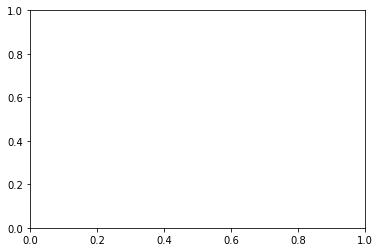

In [32]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [36]:
a = params[16]

In [37]:
b = out.eval()[0]

In [38]:
a.sum(axis=0)

array([-0.06996756, -1.30753958,  1.7047099 , -0.08115353])

In [39]:
b.sum(axis=0)

array([ 0.20003778, -1.11434238,  1.63964922, -0.31231572])

In [40]:
a

array([[ 0.22971236, -0.61925557,  0.70763764, -0.15094097],
       [-0.38289507,  0.43885698,  0.39975687, -0.40450928],
       [ 0.08321515, -1.127141  ,  0.59731539,  0.47429672]])

In [41]:
b

array([[ 0.4706526 , -0.74947427,  0.5618596 , -0.29479597],
       [-0.35467432,  0.7786525 ,  0.3084703 , -0.07287414],
       [ 0.0840595 , -1.14352062,  0.76931933,  0.05535439]])